# Cálculo de la Anomalia de Bouger

<img src='estGrav.png' width="1000" height="1000">

## Altura ortométrica: 203.552m
## $\rho=2670\frac{kg}{m^3}$
## $G$ es la constante de gravitación de Newton

<img src='Apuntes.png' width="1000" height="1000">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import osr

import geopandas as gpd

import rasterio
from rasterio.mask import mask
import geopandas as gpd

import matplotlib.ticker as mticker
from matplotlib import cm

import os

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
#from cartopy.util import add_cyclic_point
import earthpy.spatial as es

import cv2 as cv
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Cálculo de la Gravedad

In [2]:
def gN(phi):
    #g=978.049*(1+(0.0052884*(np.sin(np.radians(phi))**2))-0.0000059*(np.sin(2*np.radians(phi))**2)) #Internacional 
    g=978.0327*(1+(0.0053024*(np.sin(np.radians(phi))**2))-0.0000058*(np.sin(2*np.radians(phi))**2)) #Cassini
    return g

## Cálculo de el efecto Atmosférico

In [3]:
def catm(h):
    cat=0.874-((9.9e-5)*hgeo)+((3.56e-9)*hgeo**2)
    return cat

## Cálculo de la Anomalia de Bouger Simple

In [4]:
def AB(g,phi,hgeo):
    dgb=g+.1966389609*hgeo-gN(phi)*1000
    return dgb

## <center>$\Delta g_{B}=g_{B}-\gamma$</center>

Donde:
* $\gamma$ es la gravedad noemal dada por la ecuación de Cassini
* $g_{B}=g_{obs}+0.19663896097H$ ; siendo la $H$ la altura ortométrica en metros

In [5]:
# Ejemplo de CU

hgeo=2276.565
lat=19.33061111
g=977925.1286


AB(g,lat,hgeo) #+4.27 #cT #Cassini

-225.9346450783778

## Función para calcular la Anomalía de Bouger simple y completa

Se necistan cargar el csv correspondiente a los Bancos de Nivel Verticales y las estaciones Gravimétricas del municipio de interes

[Ir al sitio](https://www.inegi.org.mx/app/geo2/rgnp/)

In [6]:
egg=pd.read_csv('/Users/Raul/Desktop/Sexto/Geodesia 3/EGG/Monterrey/CSV_19039_EGG.csv', encoding='ISO-8859-1') # Estaciones gravimetricas
ev=pd.read_csv('/Users/Raul/Desktop/Sexto/Geodesia 3/EGG/Monterrey/CSV_19039_EGV(BN).csv', encoding='ISO-8859-1') # BNV

In [7]:
def ABmun(egg,ev): 
    sv=pd.merge(egg,ev,on='Denominación')

    c1=[]
    c2=[]
    c3=[]
    c4=[]
    c5=[]
    c6=[]
    
    for d,i,j,g,a,c,ac in zip(sv['Denominación'],sv['Latitud decimal_y'],sv['Altura Ortométrica NAVD29'],sv['Gravedad'],sv['Anomalía de Bouguer simple'],
                         sv['Corrección Topográfica'],sv['Anomalía de Bouguer completa']):

        A=AB(float(g[:-5]),i,j)
        c1.append(d)
        c2.append(A)
        c3.append(a)
        c4.append(A+float(c[:-5]))
        c5.append(ac)
        c6.append((2670*j)/(j+100*1000))
        
        #print(d,A,a,A+float(c[:-5]),ac)
    res=pd.DataFrame({'id':c1,'Bouger Cal.':c2,'Bouger Teo':c3,'Bouger Completo Cal.':c4, 'Bouger Completo Teo.':c5,'$\Delta\rho$':c6})
    
    return res

In [8]:
ABmun(egg,ev)

,id,Bouger Cal.,Bouger Teo,Bouger Completo Cal.,Bouger Completo Teo.,$\Delta\rho$
0,J_80,-103.570925,-103.2850 mGal,-101.560925,-101.4360 mGal,13.926957
1,BNT_576,-105.746098,-104.2672 mGal,-103.756098,-101.5040 mGal,14.817723
2,BNT_585,-107.621498,-106.5100 mGal,-102.931498,-101.9880 mGal,15.970991
3,V19520,-104.279001,-104.0490 mGal,-102.509001,-102.2990 mGal,14.328791
4,V19489,-103.517337,-103.2870 mGal,-101.927337,-101.7190 mGal,14.320758
5,V19488,-102.600659,-102.3710 mGal,-101.200659,-100.9880 mGal,14.171673
6,V19551,-109.273776,-109.0780 mGal,-103.683776,-102.8640 mGal,15.239356
7,V19550,-109.562406,-78.7430 mGal,-103.272406,-71.8460 mGal,14.826911
8,V19553,-108.717916,-108.4670 mGal,-103.707916,-102.8440 mGal,16.050690
9,V19549,-109.208639,-108.9190 mGal,-103.668639,-102.7570 mGal,15.121173


## Creación de archivos Raster a partir de los datos tabulares dados por el INEGI para modelos gravimétricos

[Datos del INEGI](https://www.inegi.org.mx/temas/rgnp_gravimetrica/default.html#Metadatos)

Es necesario contar con el shp de México ([Limite Nacional](http://www.conabio.gob.mx/informacion/gis/))

In [297]:
#txt del modelo gravimetrico
df=pd.read_csv('/Users/Raul/Desktop/Data/modgeoal/Anomalía por Aire Libre.txt',delim_whitespace=True,header=None,names=['lon','lat','g']) 

### Elabora un json a partir de un GeoDataFrame

In [193]:
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

### Crea una matriz (imagen) a partir de los datos del txt, regresa la matriz y su GeoTransformación con el formato de Gdal

In [248]:
def imgcreator(dt):

    ag=dt.copy()
    ag['lon']=-ag['lon']
    ag=ag.sort_values(by='lat',ascending=False)
    

    mat=[]

    for i in ag.lat.unique():
        gr=[]
        d1=ag[ag.lat==i]
        d1=d1.sort_values(by='lon')
        gr=list(np.array(d1.g))
        mat.append(gr)
    
    res=d1.lon.iloc[1]-d1.lon.iloc[0]
    
    mat=np.array(mat)
    #ggt=[ag.lon.min(),(ag.lon.max()-ag.lon.min())/mat.shape[1],0,ag.lat.max(),0,-(ag.lat.max()-ag.lat.min())/mat.shape[0]]
    ggt=[ag.lon.min()-res/2,res,0,ag.lat.max()+res/2,0,-res]

    return mat,ggt

### Crea un archivo tiff a partir de los datos de arrojados por la función imgcreator. La imagen esta en ITRF08

In [291]:
def saveImg(im,ggt,nom):
    dst_ds = gdal.GetDriverByName('GTiff').Create(nom+'.tif', im.shape[1],  im.shape[0], 1, gdal.GDT_CFloat64)
    dst_ds.SetGeoTransform(ggt)    
    srs = osr.SpatialReference()           
    srs.ImportFromEPSG(6365) # Proyeccion ITRF2008
    dst_ds.SetProjection(srs.ExportToWkt())
    dst_ds.GetRasterBand(1).WriteArray(im)   
    dst_ds.FlushCache()                     

    dst_ds = None

### Función para cortar un raster con un polígono, en particular, un estado de México

In [296]:
def clipRasEnt(rut,nn,tit):
    mex=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/dest2018gw/dest2018gw.shp')
    mex=mex.to_crs({'init': 'epsg:6365'})
    nv=mex[mex.CVE_ENT==str(nn)]
    nv=nv.to_crs({'init': 'epsg:6365'})
    coords=getFeatures(nv)
    
    data = rasterio.open(rut)
    
    out_img, out_transform = mask(data, shapes=coords, crop=True)
    pl=out_img.astype('Float32')[0]
    pl=np.where(pl==0,np.nan,pl)
    ggt2=list(out_transform)
    ggt2=[ggt2[2],ggt2[0],0,ggt2[-4],0,ggt2[-5]]
    
    #saveImg(pl,ggt2,tit+'-Ent'+str(nn))
    
    return pl,ggt2

### Integra las tres funciones anteriores. Guarda dos tif, regresa dos matrices y dos geotransformaciones correspondientes a toda la malla del txt y al territorio continenatal mexicano.

In [295]:
def fullnne(ag,nom):
    
    rr=imgcreator(ag)
    im=rr[0]
    ggt=rr[1]
    
    saveImg(im,ggt,nom)
    
    return im,ggt

In [429]:
res=fullnne(ag,'AAL')

In [ ]:
mun=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/muni_2018gw/muni_2018gw.shp')
mun=mun.to_crs({'init': 'epsg:6365'})

mex=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/dest2018gw/dest2018gw.shp')
mex=mex.to_crs({'init': 'epsg:6365'})

## Función que elabora un mapa unicamente considerando todos los datos del txt (así presenta sus cartas el INEGI)

In [446]:
def grafComp(res,tit,name,mex):

    hill1 = es.hillshade(res[0])

    plt.figure(figsize=(15,15))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ext=[res[1][0],res[1][0]+res[1][1]*res[0].shape[1],res[1][3]+res[1][-1]*res[0].shape[0],res[1][3]]
    ax.set_extent(ext, crs=ccrs.PlateCarree())

    ax.coastlines(resolution='50m',linewidth=2)
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.7,color='k',alpha=.7,linestyle='--')

    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER

    gl.xlocator=mticker.FixedLocator(np.arange(ext[0],ext[1]+6,6))
    gl.ylocator=mticker.FixedLocator(np.arange(ext[2],ext[3]+6,6))

    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}


    norm=cm.colors.Normalize(vmin=np.nanmin(res[0])/1000,vmax=np.nanmax(res[0])/1000)
    cmap=cm.rainbow
    cbar=plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax,shrink=1,orientation='horizontal',pad=.07)
    cbar.ax.tick_params(labelsize=13)
    plt.suptitle(tit,y=.81,fontsize=40,fontweight='bold')
    plt.text(-118,15,'Res: '+str(round(res[1][1],3))+'$^\circ$',fontsize=14)
    cbar.set_label('Gal',fontsize=30,labelpad=20)

        
    mex.boundary.plot(ax=ax,ec='k',linewidth=1,alpha=.5)
    
    ax.imshow(hill1, origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='gray',)

    ax.imshow(res[0], origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='jet',alpha=.7)

    #plt.savefig(name,dpi=800,bbox_inches='tight');

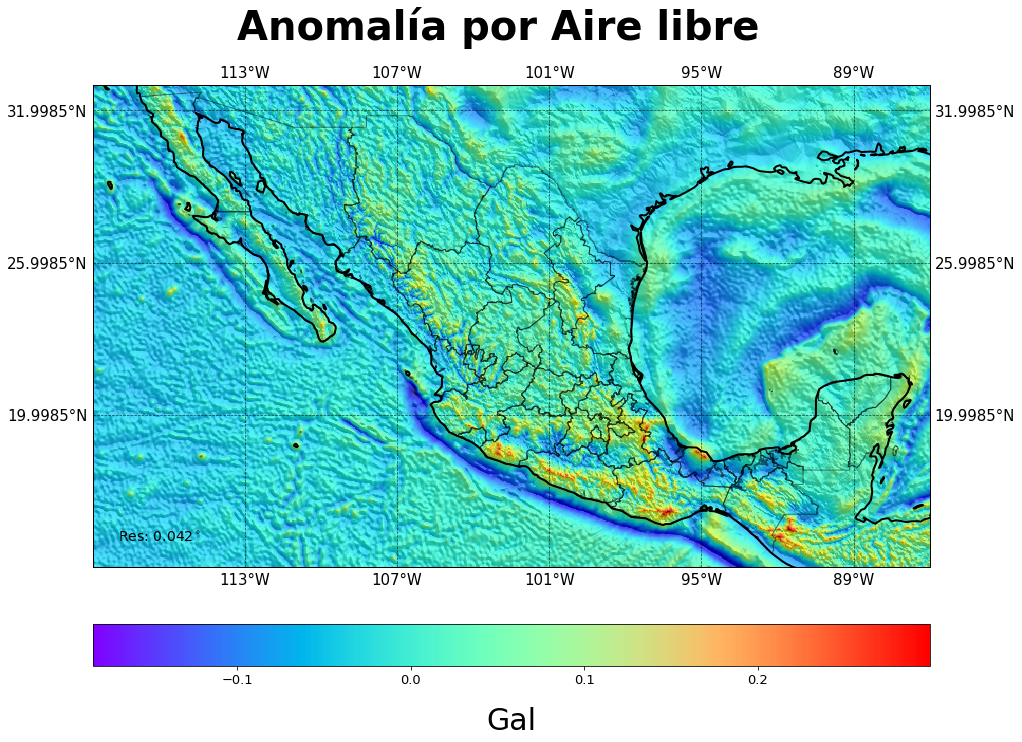

In [447]:
##Resultado de correr la función "fullnne", Titulo del Mapa, Nombre del archivo en el que se guardara, 
#Shp de los estados de méxico
grafComp(res,'Anomalía por Aire libre','BougComp.png',mex)

## Función que elabora un mapa unicamente considerando el territorio continental de México

In [425]:
rescl=clipRasEnt('AAL.tif',19,'AAL')

/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


In [427]:
def grafCor(res,tit,name,v,nn,mex,mun):
    
    

    hill= es.hillshade(res[0])

    plt.figure(figsize=(17,17))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ext=[res[1][0],res[1][0]+res[1][1]*res[0].shape[1],+res[1][3]+res[1][-1]*res[0].shape[0],res[1][3]]
    ext2=[res[1][0]-v,v+res[1][0]+res[1][1]*res[0].shape[1],-v+res[1][3]+res[1][-1]*res[0].shape[0],v+res[1][3]]
    ax.set_extent(ext2, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m',linewidth=2)
    ax.add_feature(cfeature.OCEAN,facecolor='#365383') 
    ax.add_feature(cfeature.LAND,facecolor='gray')
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.7,color='k',alpha=.7,linestyle='--')

    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER

    gl.xlocator=mticker.FixedLocator(np.arange(ext2[0],ext2[1]+1,1))
    gl.ylocator=mticker.FixedLocator(np.arange(ext2[2],ext2[3]+1,1))

    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}



    norm=cm.colors.Normalize(vmin=np.nanmin(res[0])/1000,vmax=np.nanmax(res[0])/1000)
    cmap=cm.jet
    cbar=plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax,shrink=1,pad=.15)
    cbar.ax.tick_params(labelsize=13)
    plt.suptitle(tit,y=.95,fontsize=40,fontweight='bold')
    #plt.text(-87.5,32,'Res: '+str(round(res[1][1],3))+'$^\circ$',fontsize=12)
    cbar.set_label('Gal',fontsize=30,labelpad=20)

    mun[mun.CVE_ENT=='19'].boundary.plot(ax=ax,ec='k',linewidth=1)
    mex[mex.CVE_ENT!=str(nn)].plot(ax=ax,ec='k',linewidth=3,color='#C4B899')
    
    ax.imshow(hill, origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='gray')

    ax.imshow(res[0], origin='upper', transform=ccrs.PlateCarree(),
              extent=ext, cmap='jet',alpha=.7)
    
    

    #plt.savefig(name,dpi=800,bbox_inches='tight');

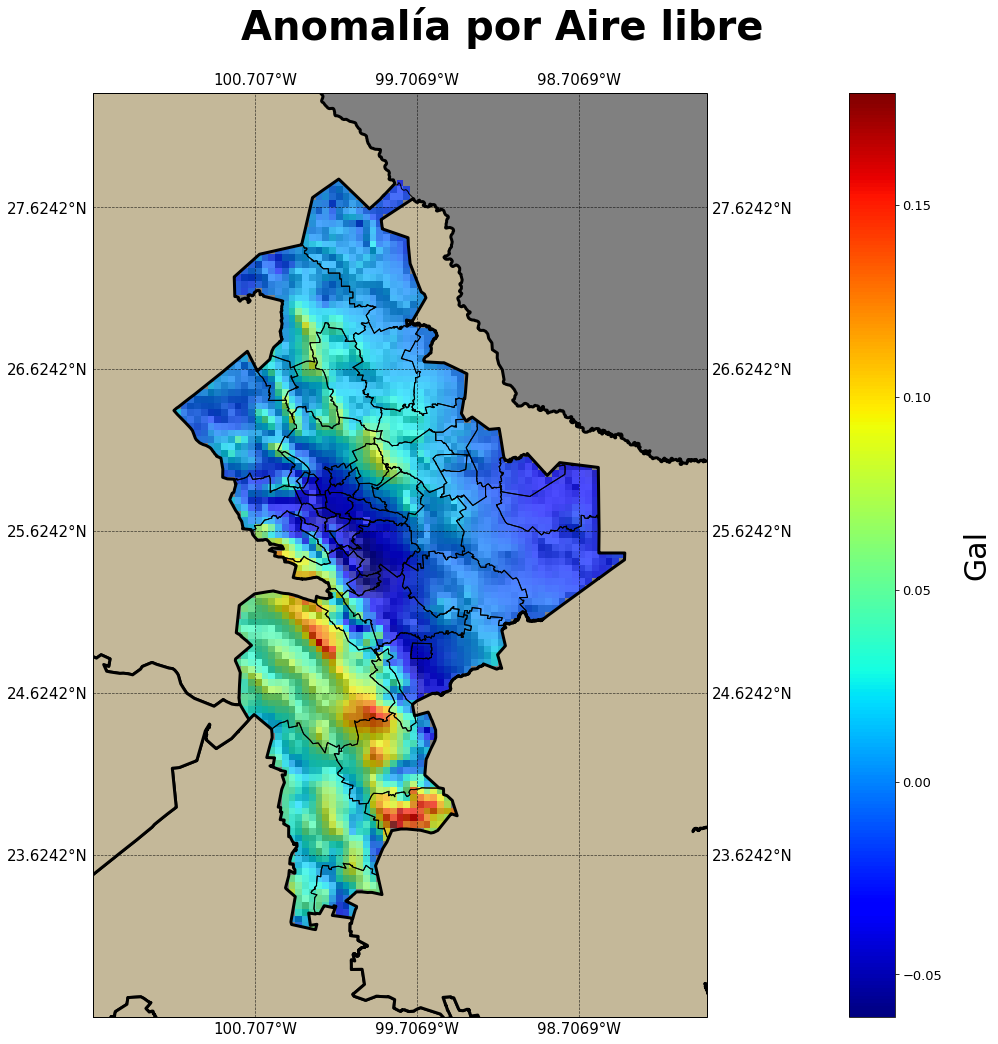

In [428]:
##Resultado de correr la función "fullnne", Titulo del Mapa, Nombre del archivo en el que se guardara,grados de separacion entre el marco 
#y el raster, clave de entidad, shp de estados, shp de muncipios
grafCor(rescl,'Anomalía por Aire libre','NLal.png',.5,19,mex,mun)

## Creación de un raster con la gravedad normal de una región a partir de una imagen georeferenciada de la región, esta imagen puede ser un dem del [CEM](https://www.inegi.org.mx/app/geo2/elevacionesmex/) o se pudo haber creado previamente a partir de un [polígono](https://desktop.arcgis.com/es/arcmap/10.3/tools/conversion-toolbox/polygon-to-raster.htm)

In [418]:
dem2=gdal.Open("AAL.tif") #Imagen creada a partir de un poligono

### Función que crea el raster con la gravedad normal de una región dada. Si el raster de entrada es muy grande se recomienda redimensionarlo multiplicandolo por $\frac{1}{rs}$, si se quiere trabajar con el tamaño original considere rs=1

In [441]:
def grav(rs,dem):
    data=np.array(dem.ReadAsArray()).astype('float')
    
    if rs!=1:
        data=cv.resize(data, dsize=(round(data.shape[1]/rs),round(data.shape[0]/rs)),interpolation=cv.INTER_CUBIC)
        
    ggt=list(dem.GetGeoTransform())
    ggt[1]=ggt[1]*rs
    ggt[-1]=ggt[-1]*rs
    for i in range(data.shape[0]):
        lt=ggt[-3]+i*ggt[-1]
        gv=gN(lt)
        data[i,:]=np.repeat(gv,len(data[i,:]))
        #data[i,:]=np.repeat(data[i,:]!=data[0,0],gv,data[i,:])
        
    #data=np.where(data==data[0,0],np.nan,data)
            
        
    return data,ggt

In [439]:
dta=grav(1,dem2)

/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


### Función de Graficación, es muy parecida a la funcion grafComp()

In [280]:
def mexGN(res,tit):   
    
    lon=[res[1][0]+i*res[1][1] for i in range(res[0].shape[1])]

    lat=[res[1][-3]+i*res[1][-1] for i in range(res[0].shape[0])]


    plt.figure(figsize=(15,15))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ext=[min(lon),max(lon),min(lat),max(lat)]
    ax.set_extent(ext, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m',linewidth=2)
    ax.add_feature(cfeature.OCEAN,facecolor='#73A1C6') 
    ax.add_feature(cfeature.LAND,facecolor='#C4B899')
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.7,color='k',alpha=.7,linestyle='--')

    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER

    gl.xlocator=mticker.FixedLocator(np.arange(ext[0],ext[1]+6,6))
    gl.ylocator=mticker.FixedLocator(np.arange(ext[2],ext[3]+6,6))

    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    norm=cm.colors.Normalize(vmin=np.nanmin(dta[0]),vmax=np.nanmax(dta[0]))
    cmap=cm.jet
    cbar=plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax,shrink=1,orientation='horizontal',pad=.07)
    cbar.ax.tick_params(labelsize=13)
    plt.suptitle(tit,y=.8,fontsize=40,fontweight='bold')
    plt.text(-118,15,'Res: '+str(round(res[1][1],3))+'$^\circ$',fontsize=15)
    cbar.set_label('Gal',fontsize=30,labelpad=20)

    ax.imshow(res[0], origin='upper', transform=ccrs.PlateCarree(),
              extent=[min(lon),max(lon),min(lat),max(lat)], cmap='jet')

#plt.savefig(name,dpi=800,bbox_inches='tight');

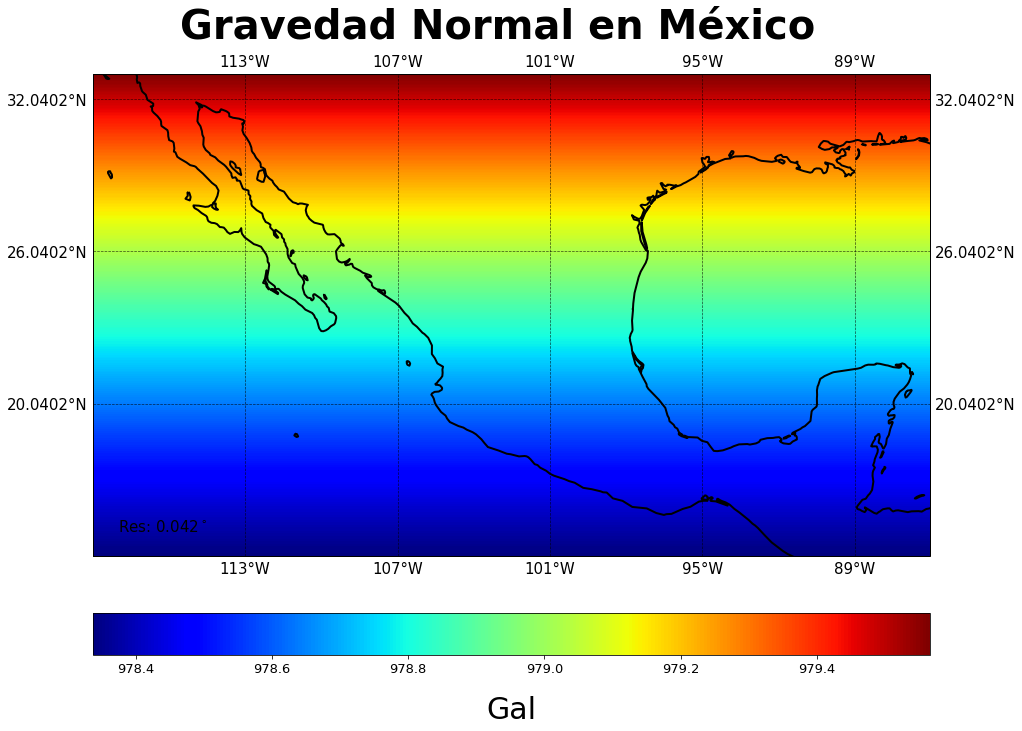

In [440]:
mexGN(dta,'Gravedad Normal en México')

In [430]:
aicor=dta[0]*1000+res[0]

In [433]:
saveImg(aicor,dta[1],'GAL')
rescl=clipRasEnt('GAL.tif',19,'GAL')

/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/Users/Raul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


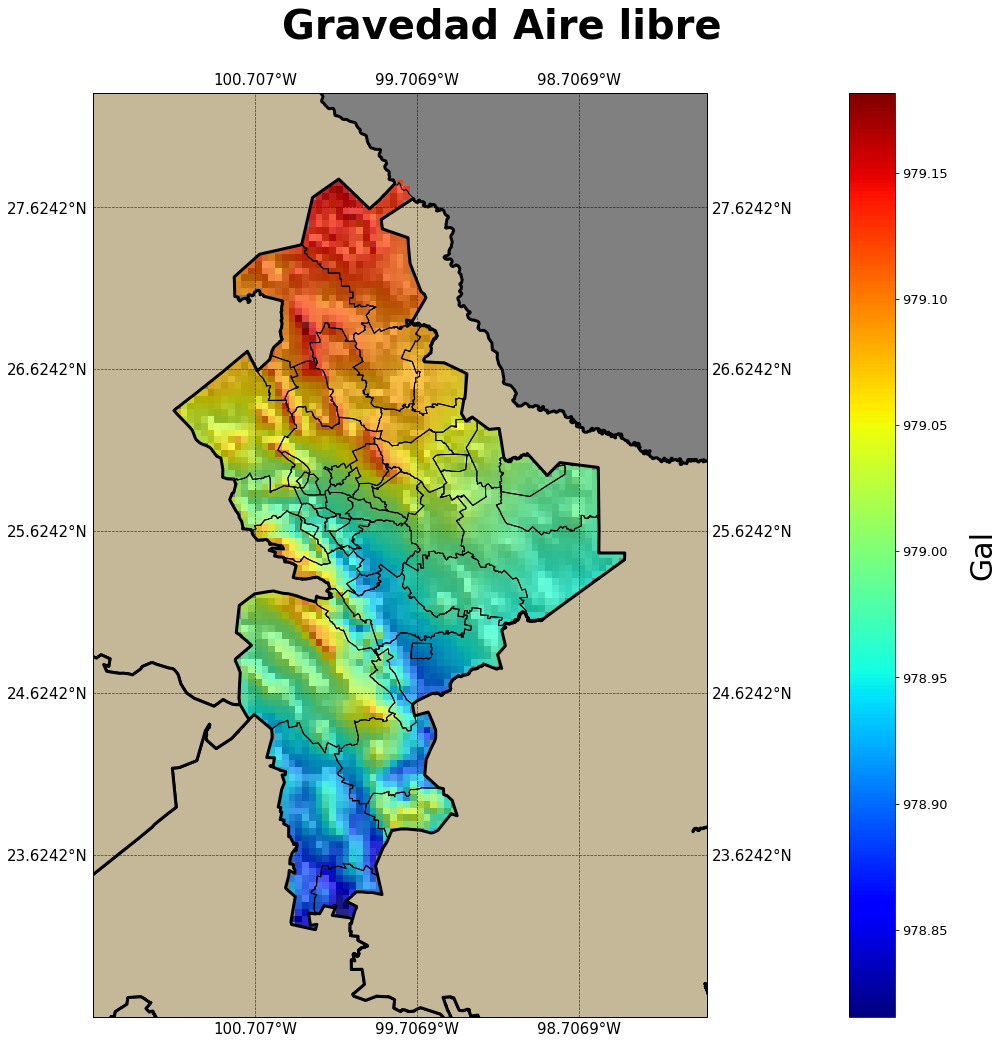

In [435]:
grafCor(rescl,'Gravedad Aire libre','NLal.png',.5,19,mex,mun)